In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import StandardScaler



from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm


from collections import Counter

from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set random seed
seed = 42

C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [3]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17425 entries, 0 to 17424
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 17425 non-null  int64  
 1   budget                17425 non-null  int64  
 2   genres                17410 non-null  object 
 3   original_language     17425 non-null  object 
 4   overview              17425 non-null  object 
 5   popularity            17425 non-null  float64
 6   production_companies  16811 non-null  object 
 7   production_countries  17253 non-null  object 
 8   revenue               17425 non-null  int64  
 9   runtime               17425 non-null  float64
 10  spoken_languages      17376 non-null  object 
 11  status                17425 non-null  object 
 12  tagline               17425 non-null  object 
 13  video                 17425 non-null  int64  
 14  vote_average          17425 non-null  float64
 15  vote_count         

# Scoring prediction

In [4]:
X = df.drop(columns=['vote_average', 'category'])
# Drop text columns
# X = X.drop(columns=['belongs_to_collection', 'tagline', 'overview'])
Y = df['category']
print(df)


       adult    budget            genres original_language  \
0          0         0     Drama,Western                en   
1          0         0       Documentary                fr   
2          0         0           History                it   
3          0         0             Drama                en   
4          0         0           Western                en   
...      ...       ...               ...               ...   
17420      0  13000000       Documentary                en   
17421      0         0             Drama                fr   
17422      0         0  Action,Adventure                en   
17423      0         0       Documentary                en   
17424      0         0       Documentary                en   

                                                overview  popularity  \
0      A fiercely independent cowboy arranges to have...       8.262   
1      Documents the lives of infamous fakers Elmyr d...       7.830   
2      While on holiday in Rhodes, Athe

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  13940
Test set size:  3485


# Feature encoding

In [6]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17425 entries, 0 to 17424
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 17425 non-null  int64  
 1   budget                17425 non-null  int64  
 2   genres                17410 non-null  object 
 3   original_language     17425 non-null  object 
 4   overview              17425 non-null  object 
 5   popularity            17425 non-null  float64
 6   production_companies  16811 non-null  object 
 7   production_countries  17253 non-null  object 
 8   revenue               17425 non-null  int64  
 9   runtime               17425 non-null  float64
 10  spoken_languages      17376 non-null  object 
 11  status                17425 non-null  object 
 12  tagline               17425 non-null  object 
 13  video                 17425 non-null  int64  
 14  vote_count            17425 non-null  float64
 15  cast               

In [7]:
print(X.head())

   adult  budget         genres original_language  \
0      0       0  Drama,Western                en   
1      0       0    Documentary                fr   
2      0       0        History                it   
3      0       0          Drama                en   
4      0       0        Western                en   

                                            overview  popularity  \
0  A fiercely independent cowboy arranges to have...       8.262   
1  Documents the lives of infamous fakers Elmyr d...       7.830   
2  While on holiday in Rhodes, Athenian war hero ...       9.668   
3  In early 1960s London, barrister Melville Farr...       5.896   
4  Respected black cavalry Sergeant Brax Rutledge...       6.003   

                                production_companies  \
0                                   Joel Productions   
1                                   SACI,Janus Films   
2  Produzioni Atlas Consorziate,Procusa,Comptoir ...   
3                                               

In [8]:
# Define numerical, categorical, boolean, and text features
from sklearn.pipeline import FunctionTransformer


numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month', 'release_day']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

list_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(list_to_str, validate=False)),
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(','), max_features=100))  # Adjust max_features as needed
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', list_transformer, 'genres'),
        ('production_companies', list_transformer, 'production_companies'),
        ('production_countries', list_transformer, 'production_countries'),
        ('cast', list_transformer, 'cast'),
        ('directors', list_transformer, 'directors')
    ]
)



# Transparent Models

## Decision Tree

### C4.5 Algorithm

Functions needed to help calculate the Information Gain Ratio to be used with the tree. Attention for being a Multi-class Classification problem (4 possible values).


In [9]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    #Portion of 'bad' = counts['bad']/np.sum(counts)
    entropy_value = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy_value

In [10]:
# 'category' has 4 possible values, so Entropy can range from 0 (perfectly pure, all values in one class) to 2 (all classes represented equally in the same number each)
e = entropy(df['category'])
elements, counts = np.unique(df['category'], return_counts=True)
print(e)
print(elements)
print(counts)

1.8363119037104076
['bad' 'good' 'great' 'mediocre']
[1794 7064 3160 5407]


In [11]:
#Information Gain -> the expected reduction in entropy (more proximate to 0 = more pure = reached decision) caused by partitioning the dataset according to split_attribute_name
#                 -> the amount of information gained by spliting the data using split_attribute_name
#                 -> higher values are better
def info_gain(data, split_attribute_name, target_name='category'):
    total_entropy = entropy(data[target_name]) #entropy(df['category'])
    
    # All possible values for the splitting attribute
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(data.where(data[split_attribute_name].astype(str) == values[i]).dropna()[target_name]) for i in range(len(values))])
    
    information_gain = total_entropy - weighted_entropy
    return information_gain

In [13]:
#igainex1 = info_gain(df, 'budget')
#print(igainex1)

#igainex2 = info_gain(df, 'popularity')
#print(igainex2)

#igainex3 = info_gain(df, 'spoken_languages')
#print(igainex3)

In [12]:
#Information Gain Ratio  ->  ratio of information gain to the intrinsic information
#                        -> reduce a bias towards multi-valued attributes by taking the number and size of branches into account when choosing an attribute, biases the decision tree against considering attributes with a large number of distinct values (ex: ID would lead to maximum purity)
#                        -> higher values are better
def info_gain_ratio(data, split_attribute_name, target_name='category'):
    information_gain = info_gain(data, split_attribute_name, target_name)
    
    # Split information = Intrinsic value  -> is a positive number that describes the potential worth of splitting a branch from a node. 
    # This in turn is the intrinsic value that the spliting attribute possesses and will be used to remove the bias in the information gain ratio calculation. (src: Wikipedia)
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    split_information = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(values))])
    
    # Avoidinge division by zero
    if split_information == 0:
        return 0
    
    # Gain ratio is the information gain divided by intrinsic value
    return information_gain / split_information

In [13]:
print(df.columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_average', 'vote_count', 'cast', 'directors', 'release_year',
       'release_month', 'release_day', 'category'],
      dtype='object')


In [16]:
#igrex1 = info_gain_ratio(df, 'budget')
#print(igrex1)

#igrex2 = info_gain_ratio(df, 'popularity')
#print(igrex2)

#igrex3 = info_gain_ratio(df, 'spoken_languages')
#print(igrex3)


In [14]:
# C4.5 Recursive Algorithm to build the Decision Tree
def c45_tree(data, original_data, features, target_name='category', parent_node_class=None):
    
    # Base case 1: If all target values are the same, return that class
    if len(np.unique(data[target_name])) <= 1:
        return np.unique(data[target_name])[0]
    
    # Base case 2: If dataset is empty, return the class of the parent node
    elif len(data) == 0:
        return parent_node_class
    
    # Base case 3: If no more features to split on, return the majority class of the current node
    elif len(features) == 0:
        return parent_node_class
    
    # Base case 4: If the data is pure (contains only one class)
    else:
        parent_node_class = np.unique(data[target_name])[np.argmax(np.unique(data[target_name], return_counts=True)[1])]
        
        # Select the feature with the highest gain ratio
        gain_ratios = [info_gain_ratio(data, feature, target_name) for feature in features]
        best_feature_index = np.argmax(gain_ratios)
        best_feature = features[best_feature_index]
        
        # Create the tree structure (dictionary)
        tree = {best_feature: {}}
        
        # Remove the best feature from the feature list
        features = [i for i in features if i != best_feature]
        
        # For each value of the best feature, split the data and recursively build the tree
        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()
        
            subtree = c45_tree(sub_data, original_data, features, target_name, parent_node_class)
            tree[best_feature][value] = subtree
        
        return tree

In [15]:
featureList = df.columns[df.columns.isin(['category', 'vote_average']) == False].tolist()


In [27]:
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

print(featureList)
print(Y_train)


X_train columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')
X_test columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')
['adult', 'budget', 'genres', 'original_language', 'overview', 'popularity', 'production_companies', 'production_countries', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'video', 'vote_count', 'cast', 'directors', 'release_year', 'release_month', 'release_day']
8936        g

In [28]:
print(pd.concat([X_train, Y_train], axis=1).columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day', 'category'],
      dtype='object')


In [29]:
#c45tree = c45_tree(df, df, featureList)
#c45tree = c45_tree(X_train, X_train, featureList)
c45tree = c45_tree(pd.concat([X_train, Y_train], axis=1), pd.concat([X_train, Y_train], axis=1), featureList)


print(c45tree)
#~30-45min

{'video': {0: {'cast': {'"Weird Al" Yankovic,Victoria Jackson,Kevin McCarthy,Michael Richards,David Bowe,Fran Drescher,Anthony Geary,Billy Barty,Trinidad Silva,Emo Philips,M.G. Kelly,Stanley Brock,Gedde Watanabe,John Paragon,Sue Ane Langdon,David Proval,Grant James,Lou B. Washington': 'good', '50 Cent,Val Kilmer,AnnaLynne McCord,James Remar,Hassan Johnson,Charles Malik Whitfield,Paul Calderon,John Larroquette,Danny Trejo,Mike Malin,Mark Famiglietti,EJ Scalzi,Josh Carrizales,Christa Campbell,La La Anthony,Malik Barnhardt,Michael Matthias,Kristin Kandrac,Jason Remar,Gil Medina,Ulysses Terrero,Elise Neal,Anthony Kennedy,Carrie Bradstreet,Jill Dugan,Keith Seccombe': 'mediocre', 'A. Michael Baldwin,Reggie Bannister,Bill Thornbury,Gloria Lynne Henry,Kevin Connors,Cindy Ambuehl,John Davis Chandler,Brooks Gardner,Angus Scrimm,Irene Roseen,Sarah Scott Davis,Duane Tucker,Claire Benedek,Wendy Way,Robert Beecher': 'mediocre', "A.J. Cook,Sebastian Roché,Simon Quarterman,Vik Sahay,Brian Scott O'Conn

In [30]:
def tree_predict(tree, sample, parent_node_class=None):
    # If the current tree node is a leaf (a class value), return that class
    if not isinstance(tree, dict):
        return tree  
    
    # The current feature to split on
    feature = next(iter(tree))
    
    # Get the value of this feature in the current sample
    feature_value = sample.get(feature, None)
    
    # Find the subtree that matches this feature value
    subtree = tree[feature].get(feature_value, None)
    
    # If the subtree is None, return the parent node's class (majority class at that node)
    if subtree is None:
        return parent_node_class
    
    # If we found a subtree, recurse into it, passing the parent class down the tree
    return tree_predict(subtree, sample, parent_node_class)


In [31]:
print(X_test.columns)  # Check the columns in X_test

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')


In [34]:
# Get the majority class of the whole dataset as the initial parent node class
parent_class = df['category'].mode()[0]

# Use the modified tree_predict function, passing the parent class at each recursive call
Y_pred = [tree_predict(c45tree, sample, parent_class) for _, sample in X_test.iterrows()]
Y_pred_encoded = label_encoder.transform(Y_pred)

print(parent_class)

good


Accuracy:  0.4
['bad', 'good', 'great', 'mediocre']
category
good        1393
mediocre    1095
great        614
bad          383
Name: count, dtype: int64


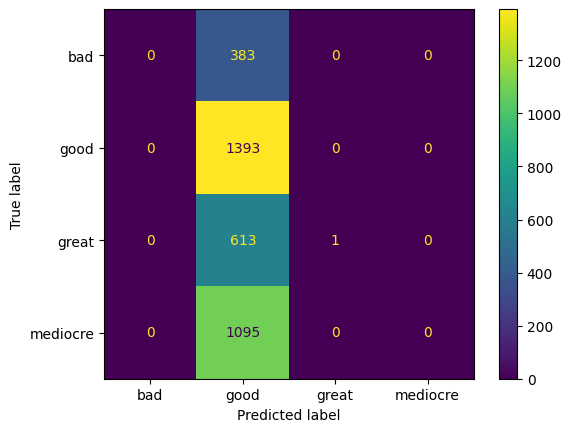

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(Y_test_encoded, Y_pred_encoded)
print("Accuracy: ", accuracy)

# Display unique values and counts
print(sorted(Y_test.unique()))
print(Y_test.value_counts())

# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(label_encoder.classes_))
disp.plot()


### CART Algorithm